#### Part 30: Advanced GroupBy and Time Series Operations

In this notebook, we'll explore:
- Grouping with ordered factors
- Using pd.Grouper for time-based grouping
- Taking specific rows from each group
- Time series partial string indexing

##### Setup
First, let's import the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Set the plotting style
plt.style.use('ggplot')

# Make plots appear in the notebook
%matplotlib inline

##### 1. Grouping with Ordered Factors

Categorical variables represented as instances of pandas's Categorical class can be used as group keys. If so, the order of the levels will be preserved:

In [2]:
# Create a Series of random data
data = pd.Series(np.random.randn(100))

# Create quartiles as an ordered categorical
factor = pd.qcut(data, [0, .25, .5, .75, 1.])

# Group by the factor and compute the mean
data.groupby(factor).mean()

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/159001472.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(factor).mean()


(-2.8009999999999997, -0.667]   -1.334221
(-0.667, -0.172]                -0.437886
(-0.172, 0.533]                  0.181594
(0.533, 2.012]                   1.010159
dtype: float64

##### 2. Grouping with a Grouper Specification

You may need to specify a bit more data to properly group. You can use the `pd.Grouper` to provide this local control, especially for time-based grouping.

In [3]:
# Create a DataFrame with date information
df = pd.DataFrame({
    'Branch': 'A A A A A A A B'.split(),
    'Buyer': 'Carl Mark Carl Carl Joe Joe Joe Carl'.split(),
    'Quantity': [1, 3, 5, 1, 8, 1, 9, 3],
    'Date': [
        datetime.datetime(2013, 1, 1, 13, 0),
        datetime.datetime(2013, 1, 1, 13, 5),
        datetime.datetime(2013, 10, 1, 20, 0),
        datetime.datetime(2013, 10, 2, 10, 0),
        datetime.datetime(2013, 10, 1, 20, 0),
        datetime.datetime(2013, 10, 2, 10, 0),
        datetime.datetime(2013, 12, 2, 12, 0),
        datetime.datetime(2013, 12, 2, 14, 0)
    ]
})
df

,Branch,Buyer,Quantity,Date
0,A,Carl,1,2013-01-01 13:00:00
1,A,Mark,3,2013-01-01 13:05:00
2,A,Carl,5,2013-10-01 20:00:00
3,A,Carl,1,2013-10-02 10:00:00
4,A,Joe,8,2013-10-01 20:00:00
5,A,Joe,1,2013-10-02 10:00:00
6,A,Joe,9,2013-12-02 12:00:00
7,B,Carl,3,2013-12-02 14:00:00


### 2.1 Groupby a Specific Column with the Desired Frequency

This is similar to resampling, but within the groupby framework:

In [4]:
# Group by month and buyer
df.groupby([pd.Grouper(freq='1M', key='Date'), 'Buyer']).sum()

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/2299244839.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(freq='1M', key='Date'), 'Buyer']).sum()


Branch  Quantity
Date       Buyer                 
2013-01-31 Carl       A         1
           Mark       A         3
2013-10-31 Carl      AA         6
           Joe       AA         9
2013-12-31 Carl       B         3
           Joe        A         9

### 2.2 Working with a DatetimeIndex

In [5]:
# Set the Date column as index
df = df.set_index('Date')

# Create a new Date column that's the index plus 2 months
df['Date'] = df.index + pd.offsets.MonthEnd(2)
df

,Branch,Buyer,Quantity,Date
Date,,,,
2013-01-01 13:00:00,A,Carl,1,2013-02-28 13:00:00
2013-01-01 13:05:00,A,Mark,3,2013-02-28 13:05:00
2013-10-01 20:00:00,A,Carl,5,2013-11-30 20:00:00
2013-10-02 10:00:00,A,Carl,1,2013-11-30 10:00:00
2013-10-01 20:00:00,A,Joe,8,2013-11-30 20:00:00
2013-10-02 10:00:00,A,Joe,1,2013-11-30 10:00:00
2013-12-02 12:00:00,A,Joe,9,2014-01-31 12:00:00
2013-12-02 14:00:00,B,Carl,3,2014-01-31 14:00:00


In [6]:
# Group by the Date column with a 6-month frequency
df.groupby([pd.Grouper(freq='6M', key='Date'), 'Buyer']).sum()

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/2343054727.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(freq='6M', key='Date'), 'Buyer']).sum()


Branch  Quantity
Date       Buyer                 
2013-02-28 Carl       A         1
           Mark       A         3
2014-02-28 Carl     AAB         9
           Joe      AAA        18

In [9]:
# Sum only the Quantity column
result = df.groupby([pd.Grouper(freq='6M', level='Date'), 'Buyer'])['Quantity'].sum()

# If you want to keep Branch in the result as well
result = df.groupby([pd.Grouper(freq='6M', level='Date'), 'Buyer', 'Branch'])['Quantity'].sum()

# If you want to sum Quantity but keep other columns in the result
result = df.groupby([pd.Grouper(freq='6M', level='Date'), 'Buyer']).agg({
    'Quantity': 'sum',
    'Branch': 'first'  # Keep the first Branch value for each group
})

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/2398199831.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  result = df.groupby([pd.Grouper(freq='6M', level='Date'), 'Buyer'])['Quantity'].sum()
/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/2398199831.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  result = df.groupby([pd.Grouper(freq='6M', level='Date'), 'Buyer', 'Branch'])['Quantity'].sum()
/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/2398199831.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  result = df.groupby([pd.Grouper(freq='6M', level='Date'), 'Buyer']).agg({


##### 3. Taking the First Rows of Each Group

Just like for a DataFrame or Series, you can call `head` and `tail` on a groupby:

In [10]:
# Create a simple DataFrame
df = pd.DataFrame([[1, 2], [1, 4], [5, 6]], columns=['A', 'B'])
df

,A,B
0,1,2
1,1,4
2,5,6


In [11]:
# Group by column A
g = df.groupby('A')

# Get the first row of each group
g.head(1)

,A,B
0,1,2
2,5,6


In [12]:
# Get the last row of each group
g.tail(1)

,A,B
1,1,4
2,5,6


##### 4. Taking the nth Row of Each Group

To select from a DataFrame or Series the nth item, use `nth()`. This is a reduction method, and will return a single row (or no row) per group if you pass an int for n:

In [13]:
# Create a DataFrame with some NaN values
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=['A', 'B'])
df

,A,B
0,1,NaN
1,1,4.0
2,5,6.0


In [14]:
# Group by column A
g = df.groupby('A')

# Get the first row (index 0) of each group
g.nth(0)

,A,B
0,1,NaN
2,5,6.0


##### 5. Time Series Operations

Let's explore some time series operations, particularly partial string indexing.

In [15]:
# Create a time series
ts = pd.Series(np.random.randn(12),
              index=pd.date_range('1/31/2011', periods=12, freq='BM'))
ts

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/1726142712.py:3: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  index=pd.date_range('1/31/2011', periods=12, freq='BM'))


2011-01-31   -0.145506
2011-02-28   -0.835868
2011-03-31    1.326737
2011-04-29   -0.278963
2011-05-31    1.848497
2011-06-30   -0.216766
2011-07-29   -1.497857
2011-08-31   -0.572548
2011-09-30   -1.756664
2011-10-31   -0.375696
2011-11-30   -1.087297
2011-12-30   -0.410286
Freq: BME, dtype: float64

### 5.1 Partial String Indexing

Dates and strings that parse to timestamps can be passed as indexing parameters:

In [16]:
# Access by date string
ts['1/31/2011']

np.float64(-0.14550550848220034)

In [17]:
# Access by datetime object
ts[datetime.datetime(2011, 12, 25):]

2011-12-30   -0.410286
Freq: BME, dtype: float64

In [18]:
# Access by date range
ts['10/31/2011':'12/31/2011']

2011-10-31   -0.375696
2011-11-30   -1.087297
2011-12-30   -0.410286
Freq: BME, dtype: float64

To provide convenience for accessing longer time series, you can also pass in the year or year and month as strings:

In [19]:
# Access all data for 2011
ts['2011']

2011-01-31   -0.145506
2011-02-28   -0.835868
2011-03-31    1.326737
2011-04-29   -0.278963
2011-05-31    1.848497
2011-06-30   -0.216766
2011-07-29   -1.497857
2011-08-31   -0.572548
2011-09-30   -1.756664
2011-10-31   -0.375696
2011-11-30   -1.087297
2011-12-30   -0.410286
Freq: BME, dtype: float64

In [20]:
# Access data for June 2011
ts['2011-6']

2011-06-30   -0.216766
Freq: BME, dtype: float64

### 5.2 Partial String Indexing with DataFrames

This type of slicing will work on a DataFrame with a DatetimeIndex as well. Since the partial string selection is a form of label slicing, the endpoints will be included.

In [24]:
# Create a DataFrame with a DatetimeIndex
dft = pd.DataFrame(np.random.randn(100000, 1), columns=['A'],
                  index=pd.date_range('20130101', periods=100000, freq='min'))
dft.head()

,A
2013-01-01 00:00:00,-1.529816
2013-01-01 00:01:00,-1.006849
2013-01-01 00:02:00,1.158796
2013-01-01 00:03:00,-0.332473
2013-01-01 00:04:00,0.267226


In [26]:
# First, make sure the index is a DatetimeIndex
if not isinstance(dft.index, pd.DatetimeIndex):
    # If Date is a column, set it as index
    if 'Date' in dft.columns:
        dft = dft.set_index('Date')
    # Or convert the existing index to datetime
    else:
        dft.index = pd.to_datetime(dft.index)

# Now access all data for 2013 using .loc
dft.loc['2013'].head()

,A
2013-01-01 00:00:00,-1.529816
2013-01-01 00:01:00,-1.006849
2013-01-01 00:02:00,1.158796
2013-01-01 00:03:00,-0.332473
2013-01-01 00:04:00,0.267226


In [27]:
# This starts on the very first time in the month, and includes the last date and time for the month
dft['2013-1':'2013-2'].head()

,A
2013-01-01 00:00:00,-1.529816
2013-01-01 00:01:00,-1.006849
2013-01-01 00:02:00,1.158796
2013-01-01 00:03:00,-0.332473
2013-01-01 00:04:00,0.267226


##### 6. Practical Examples

Let's put these concepts together in some practical examples:

In [28]:
# Create a DataFrame with sales data
dates = pd.date_range('2022-01-01', periods=365)
sales = pd.DataFrame({
    'date': dates,
    'product': np.random.choice(['A', 'B', 'C'], size=365),
    'store': np.random.choice(['North', 'South', 'East', 'West'], size=365),
    'sales': np.random.randint(100, 1000, size=365),
    'units': np.random.randint(1, 20, size=365)
})
sales.head()

,date,product,store,sales,units
0,2022-01-01,C,East,916,15
1,2022-01-02,C,North,259,9
2,2022-01-03,A,North,884,3
3,2022-01-04,B,South,640,7
4,2022-01-05,C,East,172,3


In [29]:
# Set the date as index
sales = sales.set_index('date')
sales.head()

,product,store,sales,units
date,,,,
2022-01-01,C,East,916,15
2022-01-02,C,North,259,9
2022-01-03,A,North,884,3
2022-01-04,B,South,640,7
2022-01-05,C,East,172,3


In [30]:
# Group by month and product
monthly_product_sales = sales.groupby([pd.Grouper(freq='M'), 'product']).agg({
    'sales': 'sum',
    'units': 'sum'
})
monthly_product_sales.head(10)

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/1972238923.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_product_sales = sales.groupby([pd.Grouper(freq='M'), 'product']).agg({


sales  units
date       product              
2022-01-31 A         4871     88
           B         5910     99
           C         5879    101
2022-02-28 A         8633    107
           B         5154     90
           C          957     52
2022-03-31 A         1739     31
           B         6848    137
           C         6009    130
2022-04-30 A         4639    103

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/3552348635.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_by_product = sales.groupby([pd.Grouper(freq='M'), 'product'])['sales'].sum().unstack()


<Axes: title={'center': 'Monthly Sales by Product'}, xlabel='date'>

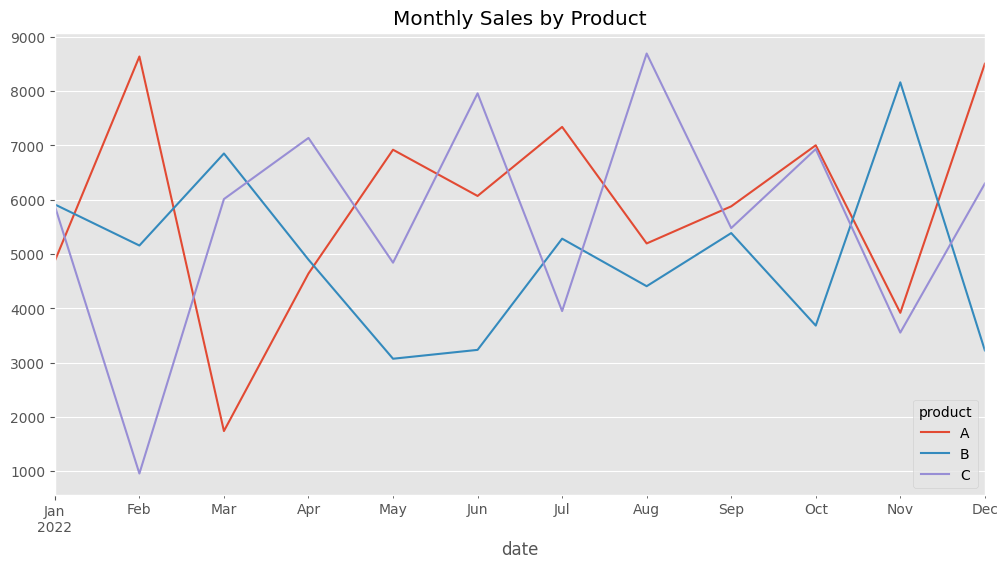

In [31]:
# Visualize monthly sales by product
monthly_sales_by_product = sales.groupby([pd.Grouper(freq='M'), 'product'])['sales'].sum().unstack()
monthly_sales_by_product.plot(figsize=(12, 6), title='Monthly Sales by Product')

In [32]:
# Get the top-selling store for each month
monthly_store_sales = sales.groupby([pd.Grouper(freq='M'), 'store'])['sales'].sum().reset_index()
top_stores = monthly_store_sales.sort_values(['date', 'sales'], ascending=[True, False]).groupby('date').head(1)
top_stores

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/509205704.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_store_sales = sales.groupby([pd.Grouper(freq='M'), 'store'])['sales'].sum().reset_index()


,date,store,sales
1,2022-01-31,North,5965
5,2022-02-28,North,5770
10,2022-03-31,South,5713
12,2022-04-30,East,7306
17,2022-05-31,North,6072
21,2022-06-30,North,6114
25,2022-07-31,North,5767
28,2022-08-31,East,6791
32,2022-09-30,East,5344
37,2022-10-31,North,6053


In [33]:
# Find the best-selling product for each quarter
quarterly_product_sales = sales.groupby([pd.Grouper(freq='Q'), 'product'])['sales'].sum().reset_index()
top_products = quarterly_product_sales.sort_values(['date', 'sales'], ascending=[True, False]).groupby('date').head(1)
top_products

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76687/1205049616.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_product_sales = sales.groupby([pd.Grouper(freq='Q'), 'product'])['sales'].sum().reset_index()


,date,product,sales
1,2022-03-31,B,17912
5,2022-06-30,C,19927
6,2022-09-30,A,18404
9,2022-12-31,A,19413


##### Summary

In this notebook, we've explored:

1. Grouping with ordered factors using categorical data
2. Using pd.Grouper for time-based grouping
   - Grouping by specific columns with desired frequencies
   - Working with DatetimeIndex
3. Taking specific rows from each group
   - Using head() and tail() on groupby objects
   - Using nth() to select specific rows
4. Time series partial string indexing
   - Accessing data by date strings
   - Accessing data by year or year-month
   - Working with DataFrames with DatetimeIndex
5. Practical examples combining these concepts

These techniques provide powerful tools for time-based analysis and grouping in pandas.